#### code to seperate out users with threshold > 30

In [4]:
from fileinput import filename
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.sparse.linalg import svds
import random 
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import scipy.stats as ss
import pickle

In [5]:
def ReadData():
    ml1m_dir = 'data/ratings.dat'
    ml1m_rating = pd.read_csv(ml1m_dir, sep='::', header=None, names=['uid', 'mid', 'rating', 'timestamp'],  engine='python')
    unique_uid = np.unique(np.array(ml1m_rating['uid'].tolist()))
    unique_mid = np.unique(np.array(ml1m_rating['mid'].tolist()))
    uid_dict = dict([(y,x) for x,y in enumerate(unique_uid)])
    mid_dict = dict([(y,x) for x,y in enumerate(unique_mid)])
    print('DICTIONARY PREPARED:')

    # init user item dictionary:
    
    uid_list = ml1m_rating['uid'].tolist()
    uid_list_len = len(uid_list)
    mid_list = ml1m_rating['mid'].tolist()
    mid_list_len = len(mid_list)
    rating_list = ml1m_rating['rating'].tolist()
    user_item_dict = {x:set() for x in range(len(unique_uid))}
    item_user_dict = {x:set() for x in range(len(unique_mid))}
    for i in range(uid_list_len):
        uid_list[i] = uid_dict[uid_list[i]]
        mid_list[i] = mid_dict[mid_list[i]]
        # rating_list[i] = 1 # comment this line if you want to activate explicit ratings
        user_item_dict[uid_list[i]].add(mid_list[i])
        item_user_dict[mid_list[i]].add(uid_list[i])
    tmp_df = pd.DataFrame({"uid":uid_list, "mid":mid_list, "ratings":rating_list})
    v = tmp_df.uid.value_counts()
    df = tmp_df[tmp_df.uid.isin(v.index[v.gt(30)])]
### code to store less than 30 interactions:
    df_less_30 = tmp_df[tmp_df.uid.isin(v.index[v.le(30)])]
    return df, df_less_30, len(np.unique(mid_list))

In [6]:
df_gt_30, df_le_30, unique_mids = ReadData()
print("GREATER THAN 30:\n", df_gt_30)
print("LESS THAN 30: \n", df_le_30)
print(len(df_gt_30))
print(len(df_le_30))
print("UNIQUE MIDS: ", unique_mids)

DICTIONARY PREPARED:
GREATER THAN 30:
           uid   mid  ratings
0           0  1104        5
1           0   639        3
2           0   853        3
3           0  3177        4
4           0  2162        5
...       ...   ...      ...
1000204  6039  1019        1
1000205  6039  1022        5
1000206  6039   548        5
1000207  6039  1024        4
1000208  6039  1025        4

[980300 rows x 3 columns]
LESS THAN 30: 
          uid   mid  ratings
233        3  3235        5
234        3  1120        3
235        3  2743        4
236        3  1124        4
237        3   971        4
...      ...   ...      ...
999740  6037  1288        2
999741  6037  2495        1
999742  6037  2511        3
999743  6037  3165        3
999744  6037  1007        5

[19909 rows x 3 columns]
980300
19909
UNIQUE MIDS:  3706


In [7]:
test_df = df_gt_30.groupby("uid").tail(1)
# print(len(df_gt_30))
train_df = df_gt_30.drop(df_gt_30.groupby('uid').tail(1).index, inplace=False)
assert(len(df_gt_30)== len(test_df) + len(train_df))
# print(len(test_df))
# print(len(train_df))
dic_train_df_uid_mapping = dict([(y,x) for x,y in enumerate(np.unique(train_df['uid']))])
dic_train_df_uid_rmapping = dict([(x,y) for x,y in enumerate(np.unique(train_df['uid']))])
### no need for mid mapping

uid_of_train_df = train_df['uid'].tolist()
for i in range(len(uid_of_train_df)):
    uid_of_train_df[i] = dic_train_df_uid_mapping[uid_of_train_df[i]]
# for index, row in train_df.iterrows():
#     train_df['uid'][index] = dic_train_df_uid_mapping[train_df['uid'][index]]
core_user_ko_input_train_df = pd.DataFrame({'uid':uid_of_train_df, 'mid':train_df['mid'], 'ratings':train_df['ratings']})

In [8]:
train_ui_dic = {}    
for user in range(6040):
    train_ui_dic[user] = []
for index,row in train_df.iterrows():
        train_ui_dic[row['uid']].append(row['mid'])

In [9]:
print(len(np.unique(train_df['mid'])))
# print(dic_train_df_uid_rmapping)

3699


In [10]:
def ExtractCoreUsers(dataframe, unique_user_len, unique_item_len):
    # print("# of rows in ml1m_ratings: ", len(dataframe))
    u_len = unique_user_len
    print("USER LEN:", u_len)
    # print(user_id)

    m_len = unique_item_len
    print("MOVIE LEN:", m_len)
    userItemMatrix = np.zeros(shape=(u_len, m_len))
    # print(userItemMatrix)

    for index, row in dataframe.iterrows():
        userItemMatrix[row['uid']][row['mid']] = row['ratings']
        # print(row['uid'], row['mid'])
    print("USER ITEM MATRIX: \n", userItemMatrix)

    df = pd.DataFrame(userItemMatrix)
    cosineSimilarity = cosine_similarity(df)
    print("SHAPE OF COSINE MATIX:\n ", cosineSimilarity.shape)

    listToStoreTopFiftyOfEveryUser = []
    for i in range(0, cosineSimilarity.shape[0]):
        idx = np.argpartition(cosineSimilarity[i], -50)[-50:]
        listToStoreTopFiftyOfEveryUser.append(idx)
    # print("Top fifty list: \n", listToStoreTopFiftyOfEveryUser)
    # listToStoreTopFiftyOfEveryUser = np.array(listToStoreTopFiftyOfEveryUser)
    flatten = np.concatenate(listToStoreTopFiftyOfEveryUser)
    listToStoreTopFiftyOfEveryUser = flatten.ravel()

    # print("List of top 50", listToStoreTopFiftyOfEveryUser)
    df = pd.DataFrame(listToStoreTopFiftyOfEveryUser)
    allUserList = df.value_counts().index.tolist()
    # print("ALL USERS LIST", allUserList)
    allUserList = list(sum(allUserList,()))
    # print("ALL USERS LIST", allUserList)
    twentyPercentUserList = allUserList[:int(len(allUserList)*0.2)]
    # print("TWENTY PERCENT USER:", len(twentyPercentUserList))
    # print("TWENTY PERCENT USER:", (twentyPercentUserList))
    coreusers = dataframe.iloc[np.where(dataframe.uid.isin(twentyPercentUserList))]
    # coreusers.reset_index()
    # print("CORE USERS:\n", coreusers)
    return coreusers

In [11]:
core_users = ExtractCoreUsers(core_user_ko_input_train_df, len(np.unique(uid_of_train_df)), unique_mids)
support_user_list = np.unique(core_users['uid'])
print("CORE USERS:" ,core_users)

USER LEN: 5231
MOVIE LEN: 3706
USER ITEM MATRIX: 
 [[5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]]
SHAPE OF COSINE MATIX:
  (5231, 5231)
CORE USERS:           uid   mid  ratings
523         5   627        4
524         5   805        4
525         5  2708        5
526         5  3341        3
527         5  3550        3
...       ...   ...      ...
1000203  5230  1018        3
1000204  5230  1019        1
1000205  5230  1022        5
1000206  5230   548        5
1000207  5230  1024        4

[366403 rows x 3 columns]


In [12]:
print(train_df['uid'][999866])
print(train_df)

6038
          uid   mid  ratings
0           0  1104        5
1           0   639        3
2           0   853        3
3           0  3177        4
4           0  2162        5
...       ...   ...      ...
1000203  6039  1018        3
1000204  6039  1019        1
1000205  6039  1022        5
1000206  6039   548        5
1000207  6039  1024        4

[975069 rows x 3 columns]


In [13]:
# print("CORE USERS:" ,core_users)
# print("UNIQUE USERS:", len(np.unique(core_users['uid'])))
core_users_index_list = core_users.index.to_list()
non_core_user_index = (train_df.index.difference(core_users.index))
non_core_user_index = non_core_user_index.tolist()

core_users_df = train_df.loc[core_users_index_list]
non_core_user_df = train_df.loc[non_core_user_index]
print("NON CORE USERS:" ,non_core_user_df)
print("CORE USERS:" ,core_users)

NON CORE USERS:          uid   mid  ratings
0          0  1104        5
1          0   639        3
2          0   853        3
3          0  3177        4
4          0  2162        5
...      ...   ...      ...
999862  6038  1006        4
999863  6038  1009        4
999864  6038  1011        3
999865  6038  1014        4
999866  6038  1016        4

[608666 rows x 3 columns]
CORE USERS:           uid   mid  ratings
523         5   627        4
524         5   805        4
525         5  2708        5
526         5  3341        3
527         5  3550        3
...       ...   ...      ...
1000203  5230  1018        3
1000204  5230  1019        1
1000205  5230  1022        5
1000206  5230   548        5
1000207  5230  1024        4

[366403 rows x 3 columns]


In [14]:
print("TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:\n" ,test_df)
# print(core_users['uid'])
unique_uids_in_support_trian = np.unique(np.array(core_users_df['uid']))
unique_uids_in_query_trian = np.unique(non_core_user_df['uid'])
print(len(unique_uids_in_support_trian))
support_test_df = test_df.loc[test_df['uid'].isin(unique_uids_in_support_trian)]
print("SUPPORT TEST DF:" ,support_test_df)
query_test_df = test_df.loc[test_df['uid'].isin(unique_uids_in_query_trian)]
print("QUERY TEST DF:\n", query_test_df)

TEST DF CONTAINS TEST FOR CORE AND NON CORE ENTITIES:
           uid   mid  ratings
52          0  1154        4
181         1  1155        5
232         2  1900        4
451         4   683        4
522         5    33        4
...       ...   ...      ...
998634   6034  1865        4
999522   6035  1867        3
999724   6036  1025        5
999867   6038  1025        4
1000208  6039  1025        4

[5231 rows x 3 columns]
1046
SUPPORT TEST DF:           uid   mid  ratings
553         6  3186        3
798         8   414        3
1199        9  1868        5
1467       12  1865        4
1693       14  1934        4
...       ...   ...      ...
997247   6020  1025        3
997889   6025  1025        5
998118   6029  1025        3
999724   6036  1025        5
1000208  6039  1025        4

[1046 rows x 3 columns]
QUERY TEST DF:
          uid   mid  ratings
52         0  1154        4
181        1  1155        5
232        2  1900        4
451        4   683        4
522        5    33   

In [15]:
support_train = []
for index,row in core_users_df.iterrows():
    support_train.append([row['uid'], row['mid'], row['ratings']])
query_train = []
for index, row in non_core_user_df.iterrows():
    query_train.append([row['uid'], row['mid'], row['ratings']])
support_test = []
for index, row in support_test_df.iterrows():
    support_test.append([row['uid'], row['mid'], row['ratings']])
query_test = []
for index, row in query_test_df.iterrows():
    query_test.append([row['uid'], row['mid'], row['ratings']])
user_his_dic = {}
for u in train_ui_dic.keys():
    user_his_dic[u] = train_ui_dic[u]
user_supp_list = np.unique(core_users_df['uid']).tolist()


In [16]:
import pickle
with open("utils_output_file_core_users.pkl", "wb") as f:
    pickle.dump(support_train, f)
    pickle.dump(query_train, f)
    pickle.dump(support_test, f)
    pickle.dump(query_test, f)
    pickle.dump(user_supp_list, f)
    pickle.dump(user_his_dic, f)

In [84]:
!python pretrain-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 366403/608666
test set size: support/query 1046/4185
Epoch 0 Step 340: Train 2.0963 Reg: 0.5619
Test: 0.8439 MAE: 0.7313 RMSE: 0.9186
Val: 0.7924 MAE: 0.7044 RMSE: 0.8902
Epoch 1 Step 680: Train 0.7729 Reg: 0.4613
Test: 0.7797 MAE: 0.7014 RMSE: 0.8830
Val: 0.7811 MAE: 0.6994 RMSE: 0.8838
Epoch 2 Step 1020: Train 0.7684 Reg: 0.3822
Test: 0.7868 MAE: 0.7054 RMSE: 0.8870
Val: 0.7808 MAE: 0.7000 RMSE: 0.8836
Epoch 3 Step 1360: Train 0.7653 Reg: 0.3303
Test: 0.7669 MAE: 0.7027 RMSE: 0.8757
Val: 0.7793 MAE: 0.6983 RMSE: 0.8828
Epoch 4 Step 1700: Train 0.7626 Reg: 0.2984
Test: 0.7830 MAE: 0.7062 RMSE: 0.8849
Val: 0.7756 MAE: 0.6963 RMSE: 0.8807
Epoch 5 Step 2040: Train 0.7586 Reg: 0.2793
Test: 0.7717 MAE: 0.7038 RMSE: 0.8784
Val: 0.7707 MAE: 0.6946 RMSE: 0.8779
Epoch 6 Step 2380: Train 0.7531 Reg: 0.2702
Test: 0.7715 MAE: 0.7011 RMSE: 0.8784
Val: 0.7647 MAE: 0.6923 RMSE: 0.8745

In [17]:
!python train-1m.py
# !python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 366403/608666
test set size: support/query 1046/4185
Epoch 0: TrainLoss 0.8931 RecLoss: 0.0000 (left: 4:48:04)
TestLoss: 0.8927 MAE: 0.7472 RMSE: 0.9448
ValLoss: 0.8433 MAE: 0.7265 RMSE: 0.9183
Epoch 1: TrainLoss 0.8482 RecLoss: 0.0000 (left: 4:49:13)
TestLoss: 0.8934 MAE: 0.7508 RMSE: 0.9452
ValLoss: 0.8411 MAE: 0.7264 RMSE: 0.9171
Epoch 2: TrainLoss 0.8454 RecLoss: 0.0000 (left: 4:45:46)
TestLoss: 0.8957 MAE: 0.7392 RMSE: 0.9464
ValLoss: 0.8459 MAE: 0.7215 RMSE: 0.9197
Epoch 3: TrainLoss 0.8439 RecLoss: 0.0000 (left: 4:38:06)
TestLoss: 0.8901 MAE: 0.7490 RMSE: 0.9435
ValLoss: 0.8407 MAE: 0.7282 RMSE: 0.9169
Epoch 4: TrainLoss 0.8418 RecLoss: 0.0000 (left: 4:28:58)
TestLoss: 0.8895 MAE: 0.7485 RMSE: 0.9431
ValLoss: 0.8383 MAE: 0.7269 RMSE: 0.9156
Epoch 5: TrainLoss 0.8388 RecLoss: 0.0000 (left: 4:19:59)
TestLoss: 0.8912 MAE: 0.7452 RMSE: 0.9440
ValLoss: 0.8359 MAE: 0.72

#### this contains the result of 20% core user as support.

In [26]:
!python test-1m.py

Extra : False
-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 366403/608666
test set size: support/query 1046/4185
USER HIS DICT: 6040
NUM IS: 6040
Key Test Result: MAE: 0.6678 RMSE: 0.8377 NDCG: 0.0000
CORE IS SELECTED:
USER HIS DICT: 6040
NUM IS: 6040
Que Test Result: MAE: 0.7366 RMSE: 0.9350 NDCG: 0.0000
All Test Result: MAE: 0.7228 RMSE: 0.9164 NDCG: 0.0000


#### 40% core users in support

In [27]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 558297/416772
test set size: support/query 2092/3139
Epoch 0 Step 518: Train 1.8030 Reg: 0.6223
Test: 0.8437 MAE: 0.7293 RMSE: 0.9185
Val: 0.7883 MAE: 0.7048 RMSE: 0.8879
Epoch 1 Step 1036: Train 0.7930 Reg: 0.4323
Test: 0.8275 MAE: 0.7253 RMSE: 0.9097
Val: 0.7850 MAE: 0.7049 RMSE: 0.8860
Epoch 2 Step 1554: Train 0.7886 Reg: 0.3444
Test: 0.8237 MAE: 0.7153 RMSE: 0.9076
Val: 0.7790 MAE: 0.7019 RMSE: 0.8826
Epoch 3 Step 2072: Train 0.7845 Reg: 0.3109
Test: 0.8173 MAE: 0.7143 RMSE: 0.9040
Val: 0.7762 MAE: 0.6987 RMSE: 0.8810
Epoch 4 Step 2590: Train 0.7797 Reg: 0.2907
Test: 0.8262 MAE: 0.7206 RMSE: 0.9090
Val: 0.7708 MAE: 0.6982 RMSE: 0.8780
Epoch 5 Step 3108: Train 0.7714 Reg: 0.2795
Test: 0.8196 MAE: 0.7193 RMSE: 0.9053
Val: 0.7583 MAE: 0.6914 RMSE: 0.8708
Epoch 6 Step 3626: Train 0.7590 Reg: 0.2817
Test: 0.8102 MAE: 0.7129 RMSE: 0.9001
Val: 0.7514 MAE: 0.6844 RMSE: 0.866

#### 10 users as core users in support

In [29]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 233956/741113
test set size: support/query 523/4708
Epoch 0 Step 218: Train 2.8406 Reg: 0.4863
Test: 0.7799 MAE: 0.6897 RMSE: 0.8831
Val: 0.7763 MAE: 0.6991 RMSE: 0.8811
Epoch 1 Step 436: Train 0.7594 Reg: 0.4383
Test: 0.7483 MAE: 0.6838 RMSE: 0.8651
Val: 0.7558 MAE: 0.6919 RMSE: 0.8694
Epoch 2 Step 654: Train 0.7488 Reg: 0.3935
Test: 0.7275 MAE: 0.6753 RMSE: 0.8529
Val: 0.7509 MAE: 0.6880 RMSE: 0.8666
Epoch 3 Step 872: Train 0.7458 Reg: 0.3592
Test: 0.7188 MAE: 0.6698 RMSE: 0.8478
Val: 0.7447 MAE: 0.6853 RMSE: 0.8630
Epoch 4 Step 1090: Train 0.7431 Reg: 0.3314
Test: 0.7091 MAE: 0.6640 RMSE: 0.8421
Val: 0.7440 MAE: 0.6841 RMSE: 0.8626
Epoch 5 Step 1308: Train 0.7402 Reg: 0.3110
Test: 0.7181 MAE: 0.6626 RMSE: 0.8474
Val: 0.7444 MAE: 0.6834 RMSE: 0.8628
Epoch 6 Step 1526: Train 0.7369 Reg: 0.2950
Test: 0.7186 MAE: 0.6720 RMSE: 0.8477
Val: 0.7392 MAE: 0.6796 RMSE: 0.8598
Ep

#### 60 % core users in support

In [30]:
!python pretrain-1m.py
!python train-1m.py
!python test-1m.py

-------Dataset Info--------
split way [threshold] with threshold 30 training_ratio 1.0
train set size: support/query 708509/266560
test set size: support/query 3138/2093
Epoch 0 Step 658: Train 1.5459 Reg: 0.6121
Test: 0.9011 MAE: 0.7494 RMSE: 0.9493
Val: 0.8290 MAE: 0.7239 RMSE: 0.9105
Epoch 1 Step 1316: Train 0.8090 Reg: 0.4047
Test: 0.9057 MAE: 0.7540 RMSE: 0.9517
Val: 0.8244 MAE: 0.7215 RMSE: 0.9080
Epoch 2 Step 1974: Train 0.8048 Reg: 0.3479
Test: 0.9090 MAE: 0.7535 RMSE: 0.9534
Val: 0.8220 MAE: 0.7200 RMSE: 0.9066
Epoch 3 Step 2632: Train 0.7988 Reg: 0.3164
Test: 0.8792 MAE: 0.7415 RMSE: 0.9377
Val: 0.8157 MAE: 0.7180 RMSE: 0.9032
Epoch 4 Step 3290: Train 0.7905 Reg: 0.2901
Test: 0.8816 MAE: 0.7445 RMSE: 0.9389
Val: 0.8047 MAE: 0.7118 RMSE: 0.8971
Epoch 5 Step 3948: Train 0.7781 Reg: 0.2756
Test: 0.8707 MAE: 0.7311 RMSE: 0.9331
Val: 0.7929 MAE: 0.7026 RMSE: 0.8904
Epoch 6 Step 4606: Train 0.7613 Reg: 0.2828
Test: 0.8426 MAE: 0.7280 RMSE: 0.9179
Val: 0.7693 MAE: 0.6952 RMSE: 0.877

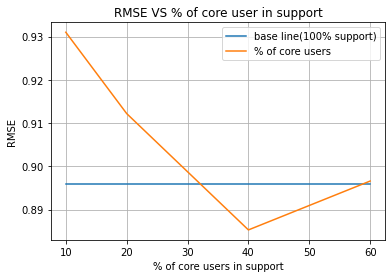

In [4]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [0.9310,0.9122,0.8853,0.8966]
x1_axis = [10, 20, 40, 60]
y1_axis = [0.8959, 0.8959, 0.8959, 0.8959]
plt.plot(x1_axis, y1_axis, label="base line(100% support)")
plt.plot(x_axis, y_axis, label="% of core users")
plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

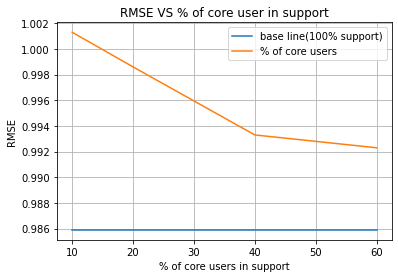

In [6]:
import matplotlib.pyplot as plt

x_axis = [10, 20, 40, 60]
y_axis = [1.0013,0.9986,0.9933, 0.9923]
x1_axis = [10, 20, 40, 60]
y1_axis = [0.9859, 0.9859, 0.9859, 0.9859]
plt.plot(x1_axis, y1_axis, label="base line(100% support)")
plt.plot(x_axis, y_axis, label="% of core users")
plt.title('RMSE VS % of core user in support')
plt.xlabel('% of core users in support')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()